## Project

### Preprocessing data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_excel('AirQualityUCI.xlsx')
df['time_str'] = df['Time'].astype(str)

# Combine "date" and "time_str" columns into a new "datetime" column
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['time_str'])

# Drop the original "date" and "time" columns if needed
df.drop(['Date', 'Time', 'time_str'], axis=1, inplace=True)
df.head(1)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.0,150,11.881723,1045.5,166.0,1056.25,113.0,1692.0,1267.5,13.6,48.875001,0.757754,2004-03-10 18:00:00


In [2]:
datetime_column = df.pop('datetime')
df.insert(0, 'datetime', datetime_column)
df.replace(-200, float('nan'), inplace=True)
# df.isnull().sum() # check how many null value in each column

df = df.drop(columns= "NMHC(GT)") # too many missing values
df = df.fillna(df.mean(numeric_only=True)) # replaces all NaN values with the mean value of each column
# df.isnull().sum()
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})

# print(df.dtypes)
print(df.shape)
print(df.size)

(9357, 13)
121641


### Test on 20% dataset

In [88]:
from statsmodels.tsa.stattools import grangercausalitytests

df_original = df[['CO(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)','PT08.S5(O3)','T']].copy()
df_original.dropna(inplace=True)

df_original_sample = df_original.sample(frac=0.2, random_state=42)

feature_names = ['CO(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)']

for feature in feature_names:
    data_dict = {
        feature: df_original_sample[feature].values,  # Accessing the feature column directly
        'T': df_original_sample['T'].values
    }
    df_before = pd.DataFrame(data=data_dict)
    
    print(f"Testing Causal Effect of {feature} on T:")
    grangercausalitytests(df_before[[feature, 'T']], maxlag=10)
    
    print(f"Testing Causal Effect of T on {feature}:")
    grangercausalitytests(df_before[['T', feature]], maxlag=10)

Testing Causal Effect of CO(GT) on T:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0231  , p=0.8792  , df_denom=1867, df_num=1
ssr based chi2 test:   chi2=0.0232  , p=0.8790  , df=1
likelihood ratio test: chi2=0.0232  , p=0.8790  , df=1
parameter F test:         F=0.0231  , p=0.8792  , df_denom=1867, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0129  , p=0.9872  , df_denom=1864, df_num=2
ssr based chi2 test:   chi2=0.0258  , p=0.9872  , df=2
likelihood ratio test: chi2=0.0258  , p=0.9872  , df=2
parameter F test:         F=0.0129  , p=0.9872  , df_denom=1864, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1208  , p=0.9479  , df_denom=1861, df_num=3
ssr based chi2 test:   chi2=0.3639  , p=0.9476  , df=3
likelihood ratio test: chi2=0.3639  , p=0.9476  , df=3
parameter F test:         F=0.1208  , p=0.9479  , df_denom=1861, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

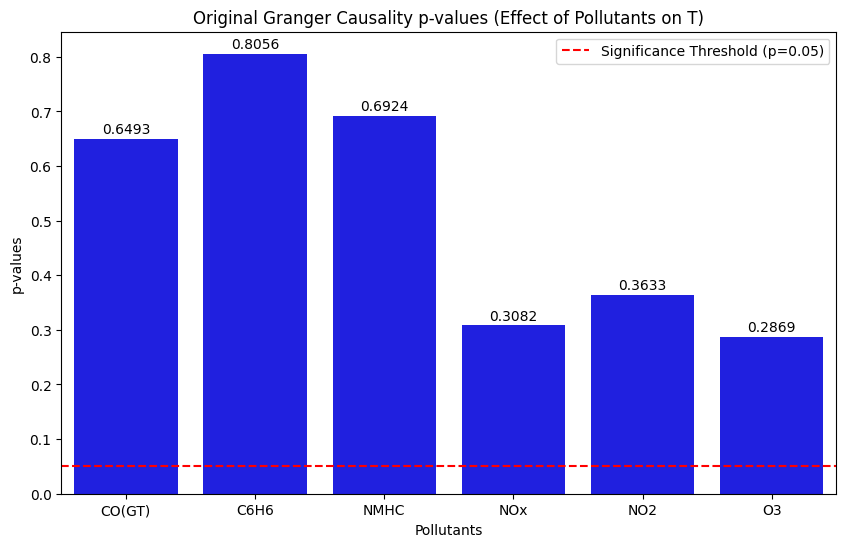

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
p_values = [0.6493, 0.8056, 0.6924, 0.3082, 0.3633, 0.2869]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='blue')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Original Granger Causality p-values (Effect of Pollutants on T)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value + 0.01, f'{p_value:.4f}', ha='center', color='black')

plt.show()

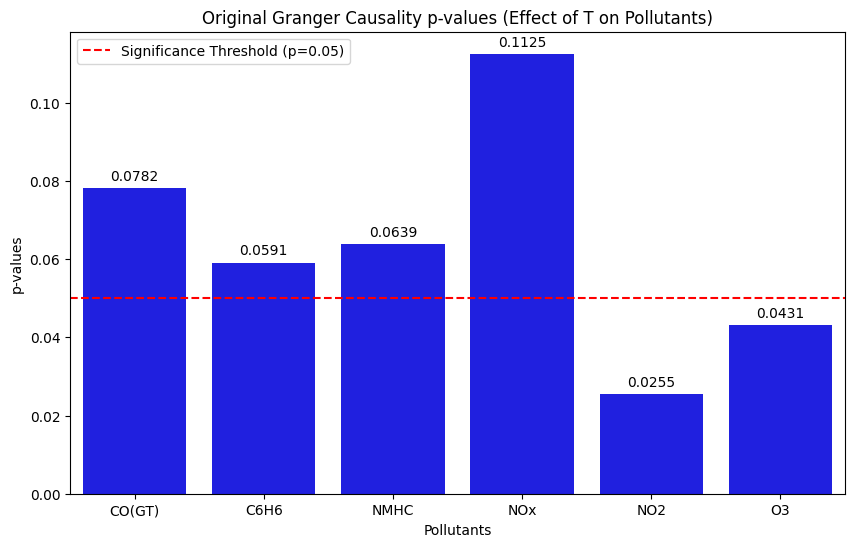

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
p_values = [0.0782, 0.0591, 0.0639, 0.1125, 0.0255, 0.0431]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='blue')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Original Granger Causality p-values (Effect of T on Pollutants)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value+0.002, f'{p_value:.4f}', ha='center', color='black')

plt.show()

### Test on full dataset

In [73]:
for feature in feature_names:
    data_dict = {
        feature: df_original[feature].values,  # Accessing the feature column directly
        'T': df_original['T'].values
    }
    df_before = pd.DataFrame(data=data_dict)
    
    print(f"Testing Causal Effect of {feature} on T:")
    grangercausalitytests(df_before[[feature, 'T']], maxlag=10)
    
    print(f"Testing Causal Effect of T on {feature}:")
    grangercausalitytests(df_before[['T', feature]], maxlag=10)

Testing Causal Effect of CO(GT) on T:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=0.0783  , p=0.7796  , df=1
likelihood ratio test: chi2=0.0783  , p=0.7796  , df=1
parameter F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9294  , p=0.3948  , df_denom=9350, df_num=2
ssr based chi2 test:   chi2=1.8597  , p=0.3946  , df=2
likelihood ratio test: chi2=1.8595  , p=0.3946  , df=2
parameter F test:         F=0.9294  , p=0.3948  , df_denom=9350, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.3664  , p=0.0000  , df_denom=9347, df_num=3
ssr based chi2 test:   chi2=28.1202 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0780 , p=0.0000  , df=3
parameter F test:         F=9.3664  , p=0.0000  , df_denom=9347, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

### Heatmap

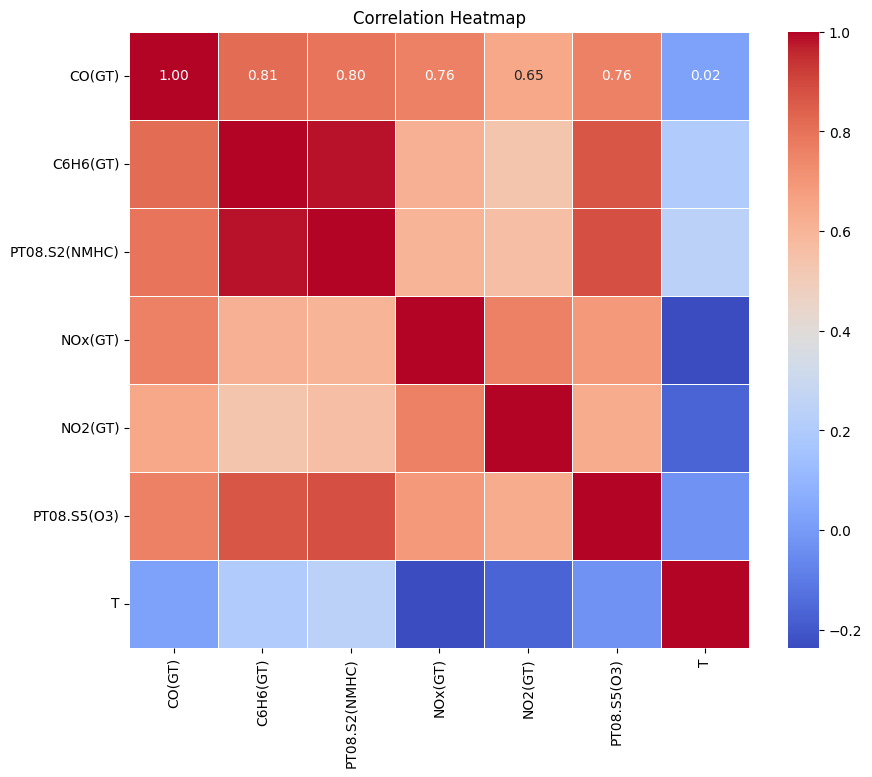

In [87]:
import seaborn as sns
# Create a heatmap

df_T_heatmap = df.drop(columns=['PT08.S1(CO)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'RH', 'AH'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_T_heatmap.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### plots: Time Series of Pollutants and Temperature

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = df.copy()
# Ensure 'datetime' is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' as the index
data.set_index('datetime', inplace=True)

# Plot 1: CO(GT), C6H6(GT), PT08.S2(NMHC), T
plt.figure(figsize=(14, 8))
for feature in ['CO(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'T']:
    plt.plot(data.index, data[feature], label=feature)

plt.title('Time Series of Pollutants and Temperature (Plot 1)')
plt.xlabel('Date')
plt.ylabel('Concentration / Temperature')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)  # Horizontal line at y=0 for reference
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

# Plot 2: NOx(GT), NO2(GT), PT08.S5(O3), T
plt.figure(figsize=(14, 8))
for feature in ['NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T']:
    plt.plot(data.index, data[feature], label=feature)

plt.title('Time Series of Pollutants and Temperature (Plot 2)')
plt.xlabel('Date')
plt.ylabel('Concentration / Temperature')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)  # Horizontal line at y=0 for reference
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

### Cluster

c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


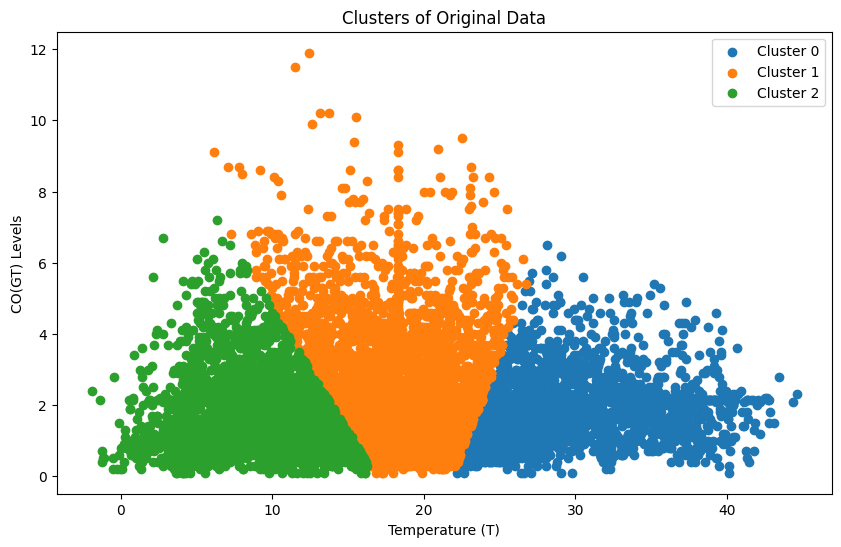

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# df is DataFrame and 'T' and 'CO(GT)' are the columns of interest
# If there are more features, we can use them

# Standardize the data
df_cluster = df.copy()

features = ['T', 'CO(GT)']
X = df_cluster[features].values
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose the number of clusters
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot the clustered data
plt.figure(figsize=(10, 6))
for cluster in np.unique(df_cluster['Cluster']):
    subset = df_cluster[df_cluster['Cluster'] == cluster]
    plt.scatter(subset['T'], subset['CO(GT)'], label=f'Cluster {cluster}')

plt.xlabel('Temperature (T)')
plt.ylabel('CO(GT) Levels')
plt.title('Clusters of Original Data')
plt.legend()
plt.show()


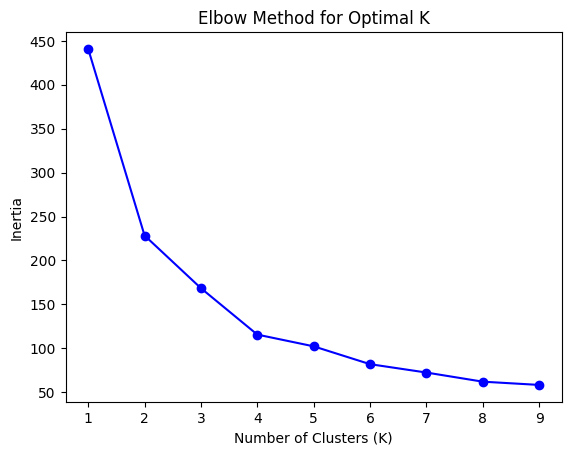

In [6]:
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [7]:
for cluster in df_cluster['Cluster'].unique():
    print(f"Cluster {cluster} mean values:\n", df_cluster[df_cluster['Cluster'] == cluster][['T', 'CO(GT)']].mean())

Cluster 1 mean values:
 T         18.351425
CO(GT)     2.603059
dtype: float32
Cluster 2 mean values:
 T         8.980112
CO(GT)    1.719346
dtype: float32
Cluster 0 mean values:
 T         29.529284
CO(GT)     1.951447
dtype: float32


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df_t = df.drop(columns= "datetime")
features = df_t.drop(columns=['CO(GT)'])  # 'target_column'
target = df_t['CO(GT)']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_components = tsne.fit_transform(features_scaled)
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

# Combine with the target
final_tsne_df = pd.concat([tsne_df, target], axis=1)

# Get unique labels and assign colors
unique_labels = final_tsne_df['CO(GT)'].unique()
num_labels = len(unique_labels)
palette = sns.color_palette("husl", num_labels)

# Create a dictionary mapping labels to colors
label_color_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot the t-SNE result
plt.figure(figsize=(14, 10))
for label in unique_labels:
    indices = final_tsne_df['CO(GT)'] == label
    plt.scatter(final_tsne_df.loc[indices, 'TSNE1'], final_tsne_df.loc[indices, 'TSNE2'], 
                color=label_color_dict[label], label=label, s=10)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Original CO(GT) Data')
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


### ICA

In [8]:
# ICA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import pandas as pd

datetime_col = df['datetime']
numerical_cols = df.drop('datetime', axis=1)

# Preprocessing: Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_cols)

# Combine the normalized numerical columns with the datetime column
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols.columns)
scaled_df.insert(0, 'datetime', datetime_col)

# number of components
n_components = 5

ica = FastICA(n_components=n_components, random_state=0)
ica_components = ica.fit_transform(scaled_data)

# Transform the data to get the independent components
df_ica = pd.DataFrame(ica_components, columns=[f'IC{i+1}' for i in range(n_components)])
df_ica.insert(0, 'datetime', datetime_col)
df_ica


,datetime,IC1,IC2,IC3,IC4,IC5
0,2004-03-10 18:00:00,0.979399,-0.133802,0.147625,0.408205,2.230674
1,2004-03-10 19:00:00,1.561341,-0.215768,0.548284,0.471214,2.278429
2,2004-03-10 20:00:00,1.926330,0.048814,0.157656,0.579651,2.211562
3,2004-03-10 21:00:00,2.071005,0.347317,-0.079636,0.610090,2.056185
4,2004-03-10 22:00:00,2.547331,0.293609,0.135666,0.641154,1.834576
...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,0.067252,-1.365829,-1.522195,0.051459,-0.286424
9353,2005-04-04 11:00:00,0.050893,-1.776561,-0.982216,-0.068920,-0.666638
9354,2005-04-04 12:00:00,0.021879,-2.170818,-0.785968,-0.197953,-0.508061
9355,2005-04-04 13:00:00,0.011484,-2.565657,-0.348939,-0.082544,-0.859079


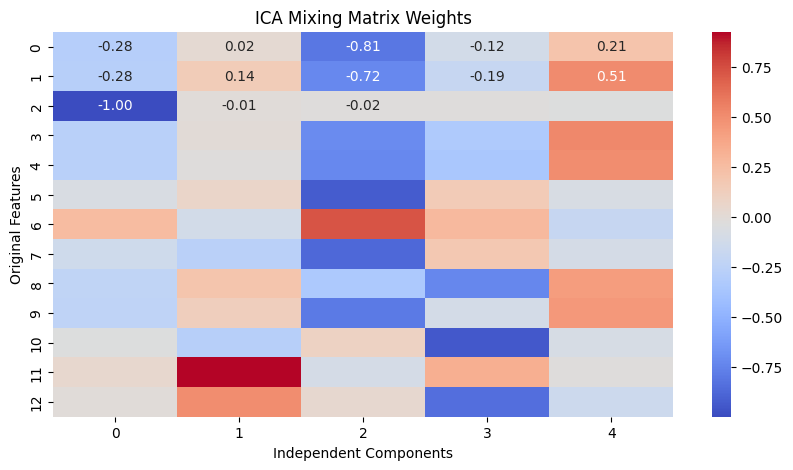

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'ica' is your fitted FastICA model
mixing_matrix = ica.mixing_

# Plotting the mixing matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(mixing_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('ICA Mixing Matrix Weights')
plt.xlabel('Independent Components')
plt.ylabel('Original Features')
plt.show()


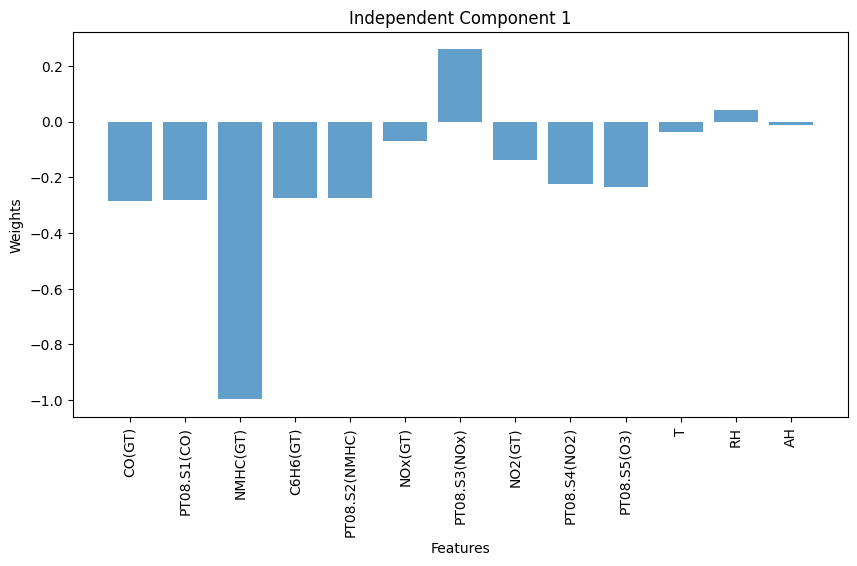

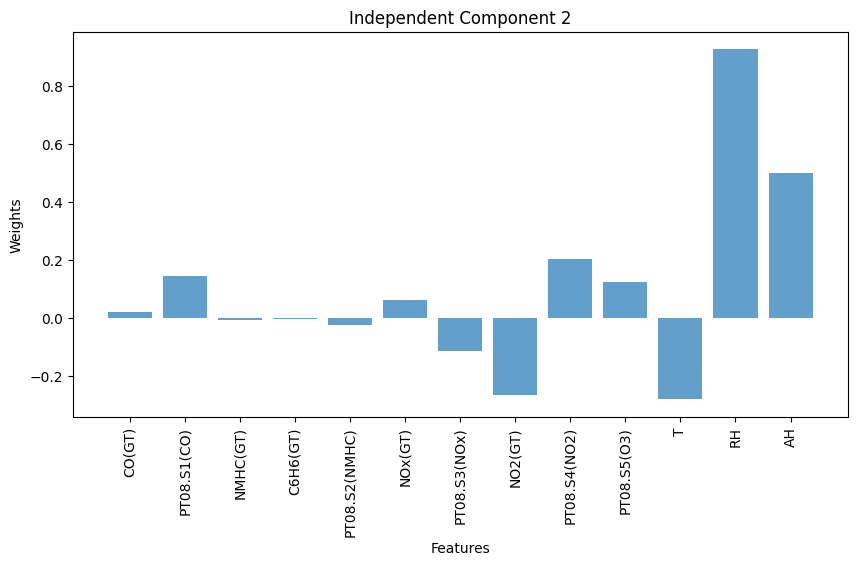

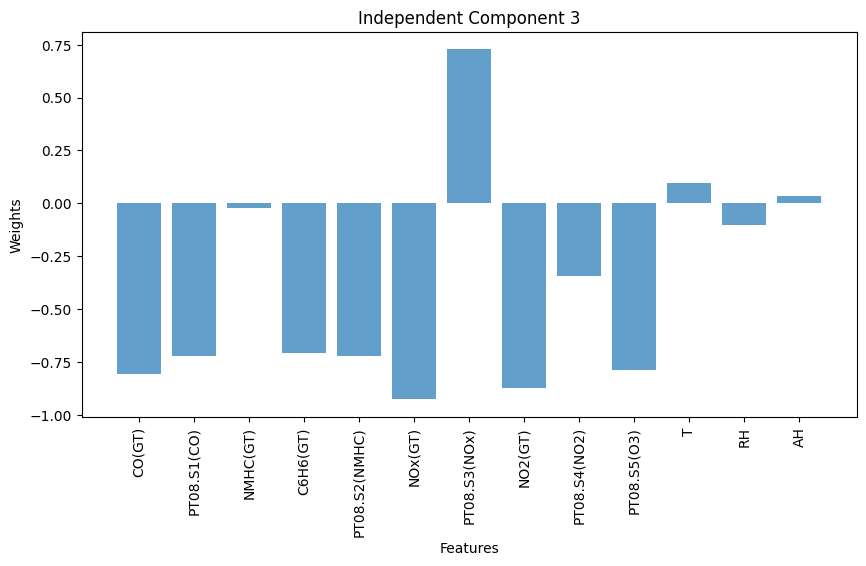

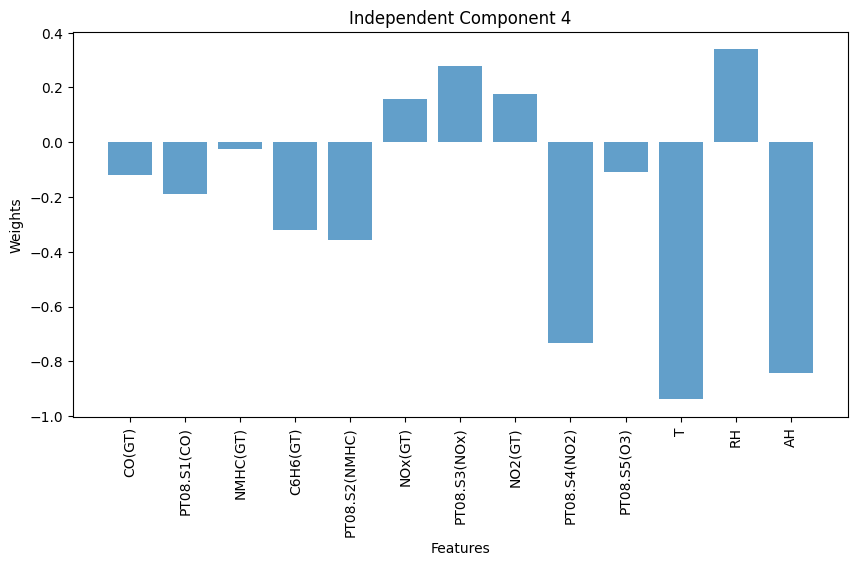

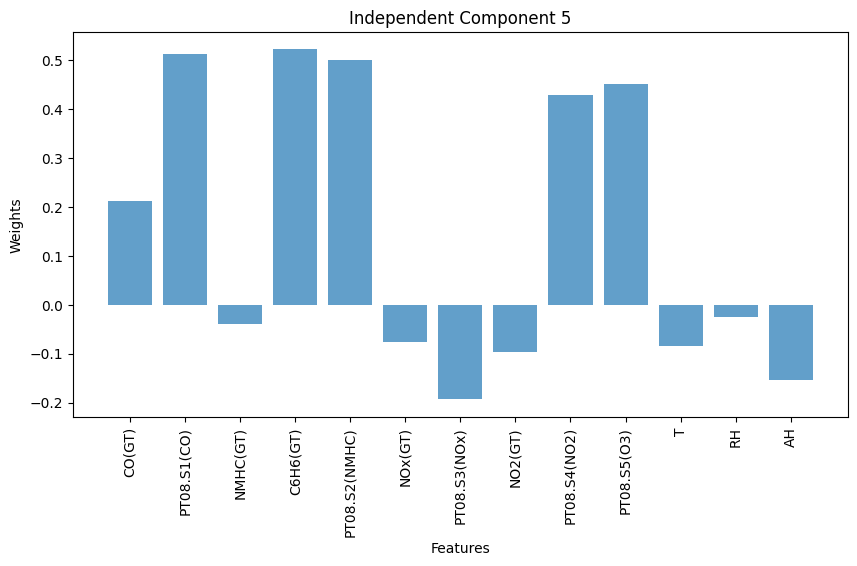

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'ica' is your fitted FastICA model and 'df' is your original DataFrame
mixing_matrix = ica.mixing_
feature_names = df.drop('datetime', axis=1).columns
n_components = mixing_matrix.shape[1]

# Create a bar chart for each independent component
for i in range(n_components):
    plt.figure(figsize=(10, 5))
    # Extract the weights for the i-th component
    weights = mixing_matrix[:, i]
    # Create an index for each tick position
    idx = np.arange(len(feature_names))
    plt.bar(idx, weights, align='center', alpha=0.7)
    plt.xticks(idx, feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Weights')
    plt.title(f'Independent Component {i+1}')
    plt.show()


### VAE

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Layer, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def total_correlation(z, mean, log_var):
    # Calculate log(q(z|x)) - log(prod_i q(z_i|x))
    log_qz_given_x = -0.5 * (tf.reduce_sum(log_var + tf.square(z - mean) / tf.exp(log_var), axis=1) + tf.math.log(2 * np.pi))
    log_qz = tf.reduce_logsumexp(log_qz_given_x, axis=0) - tf.math.log(tf.cast(tf.shape(z)[0], tf.float32))
    log_prod_qzi_given_x = tf.reduce_sum(-0.5 * (log_var + tf.square(z - mean) / tf.exp(log_var) + tf.math.log(2 * np.pi)), axis=1)
    tc = tf.reduce_mean(log_qz - log_prod_qzi_given_x)
    return tc

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_layer, reconstruction, mean_layer, log_var_layer, latent_space = inputs
        #reconstruction_loss = MeanSquaredError()(input_layer, reconstruction)
        reconstruction_loss = MeanAbsoluteError()(input_layer, reconstruction)
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var_layer - tf.square(mean_layer) - tf.exp(log_var_layer), axis=-1)
        
        # Calculate Total Correlation Loss
        tc_loss = total_correlation(latent_space, mean_layer, log_var_layer)
        
        beta = 0.01  # Scaling KL term
        total_loss = reconstruction_loss + kl_loss *beta + tc_loss *0.01
        self.add_loss(tf.reduce_mean(total_loss))
        
        return reconstruction
    
class VAE:
    def __init__(self, input_shape, latent_dim):

        self.input_shape = input_shape  # This should be a tuple
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def build_encoder(self):
        input_layer = Input(shape=self.input_shape)

        hidden_layer1 = Dense(512, activation='relu')(input_layer)  # Increased units
        hidden_layer2 = Dense(256, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(128, activation='relu')(hidden_layer2)
        hidden_layer4 = Dense(64, activation='relu')(hidden_layer3)  # Added layer

        #  the mean of the Gaussian distribution in the latent space
        mean_layer = Dense(self.latent_dim)(hidden_layer4)

        # the log of the variance of the Gaussian distribution in the latent space
        log_var_layer = Dense(self.latent_dim)(hidden_layer4)

        # reparameterization
        def sampling(args):
            mean, log_var = args            # the mean and log variance of the latent distribution
            batch = tf.shape(mean)[0]       # computes the batch size from the shape of the mean tensor
            dim = tf.shape(mean)[1]         # computes the dimensionality of the latent space from the shape of the mean tensor

            # generates a tensor of random values from a standard normal distribution with the same shape as the mean tensor
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return mean + tf.exp(0.5 * log_var) * epsilon  # applies the reparameterization trick
                                                           # allows the model to backpropagate gradients through the sampling operation

        latent_space = Lambda(sampling)([mean_layer, log_var_layer])

        encoder = Model(input_layer, [mean_layer, log_var_layer, latent_space], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        
        hidden_layer1 = Dense(64, activation='relu')(latent_inputs)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        #hidden_layer4 = Dense(512, activation='relu')(hidden_layer3)  # Added layer
        
        flat_output = Dense(np.prod(self.input_shape), activation='sigmoid')(hidden_layer3)
        output_layer = Reshape(self.input_shape)(flat_output)  # Reshape output to match input shape

        decoder = Model(latent_inputs, output_layer, name='decoder')
        return decoder

    
    # In VAE class, modify the build_vae method to use the custom VAELossLayer
    def build_vae(self):
        input_layer = Input(shape=self.input_shape)
        mean_layer, log_var_layer, latent_space = self.encoder(input_layer)
        reconstruction = self.decoder(latent_space)

        # Use the custom VAELossLayer
        output_with_loss = VAELossLayer()([input_layer, reconstruction, mean_layer, log_var_layer, latent_space])

        vae = Model(input_layer, output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.0001))  # Adjusted learning rate
        return vae


    def train(self, x_train, x_val, batch_size, epochs):
        self.vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, x_val), verbose=1)

    def encode(self, x):
        return self.encoder.predict(x)

    def decode(self, z):
        return self.decoder.predict(z)
    
    def predict(self, x):
        return self.vae.predict(x) # Reconstruct input data


### Causal effect of 'Temperature' (T) on 'CO(GT)'

In [73]:
print(df.head(1))
print(df.shape)

     CO(GT)         T
0 -0.800109 -0.540349
(1872, 2)


In [53]:
# df['Timestamp'] = df['datetime'].astype(np.int64) / 10**9

# Drop the original datetime column
df_copy = df.copy()
df_copy.drop('datetime', axis=1, inplace=True)

#### train VAE

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_copy)

# Ensure data is a numpy array for TensorFlow
data_scaled = np.array(data_scaled)
x_train, x_val = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Define and train the VAE
vae = VAE(input_shape=x_train.shape[1:], latent_dim=2)
vae.train(x_train, x_val, batch_size=64, epochs=30)

# vae.train(data_scaled, batch_size=32, epochs=30)


Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2215 - val_loss: 0.1540
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1435 - val_loss: 0.1318
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 - val_loss: 0.1223
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1195 - val_loss: 0.1162
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1143 - val_loss: 0.1122
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1115 - val_loss: 0.1098
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1087 - val_loss: 0.1084
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1065 - val_loss: 0.1044
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1014 - val_loss: 0.0998
Epoch 10/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0992 - val_loss: 0.0983
Epoch 11/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0991 - val_loss: 0.0976
Epoch 12/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [55]:
# Calculate reconstruction loss on the validation set
reconstruction_train = vae.predict(x_train)
reconstruction_loss_train = MeanSquaredError()(x_train, reconstruction_train).numpy()

# Reconstruct the validation set
reconstruction_val = vae.predict(x_val)
reconstruction_loss_val = MeanSquaredError()(x_val, reconstruction_val).numpy()

# Calculate reconstruction loss
print(f"Reconstruction Loss on Training Set: {reconstruction_loss_train}")
print(f"Reconstruction Loss on Validation Set: {reconstruction_loss_val}")


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction Loss on Training Set: 0.007194671779870987
Reconstruction Loss on Validation Set: 0.007200160995125771


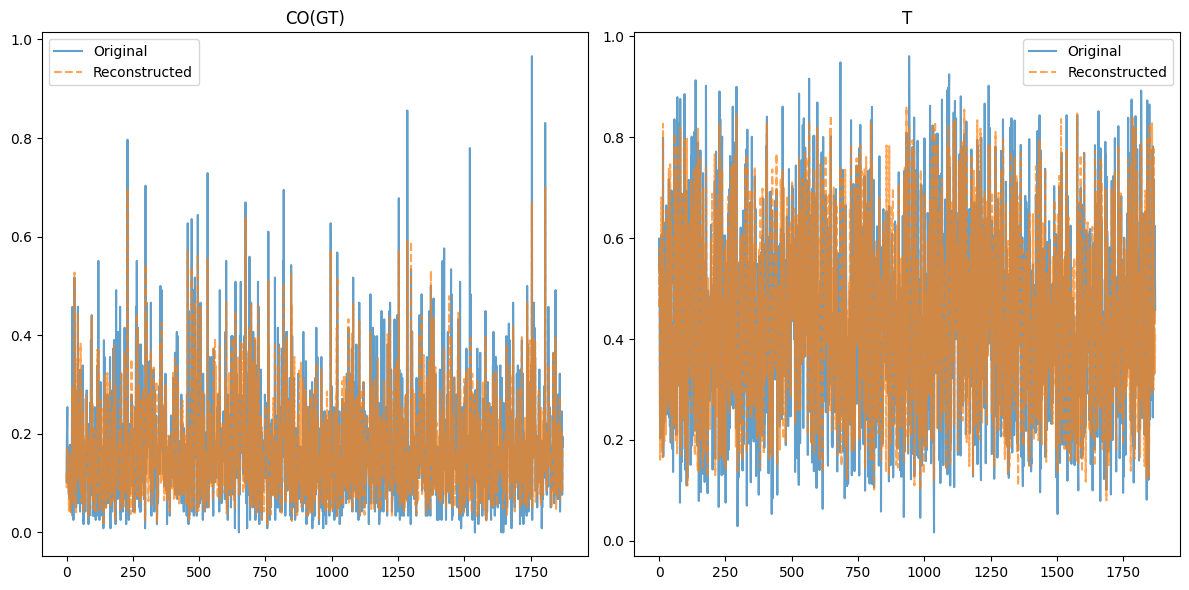

In [57]:
# Plot reconstructions for the validation set
import matplotlib.pyplot as plt

def plot_reconstruction(original, reconstructed, selected_features, feature_names):
    plt.figure(figsize=(12, 6))
    
    for i, feature_idx in enumerate(selected_features):
        plt.subplot(1, len(selected_features), i + 1)
        plt.plot(original[:, feature_idx], label='Original', alpha=0.7)
        plt.plot(reconstructed[:, feature_idx], label='Reconstructed', linestyle='dashed', alpha=0.7)
        plt.title(f'{feature_names[i]}')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

selected_features = [0, 9]  # 'CO(GT)' at index 0 and 'T' at index 9
feature_names = ['CO(GT)', 'T']
plot_reconstruction(x_val, reconstruction_val, selected_features, feature_names) # features from the original dataset

In [58]:
print(f"x_val shape: {x_val.shape}")
#print(f"reconstructed_val shape: {reconstructed_val.shape}")
print(f"reconstruction_val shape: {reconstruction_val.shape}")

x_val shape: (1872, 12)
reconstruction_val shape: (1872, 12)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


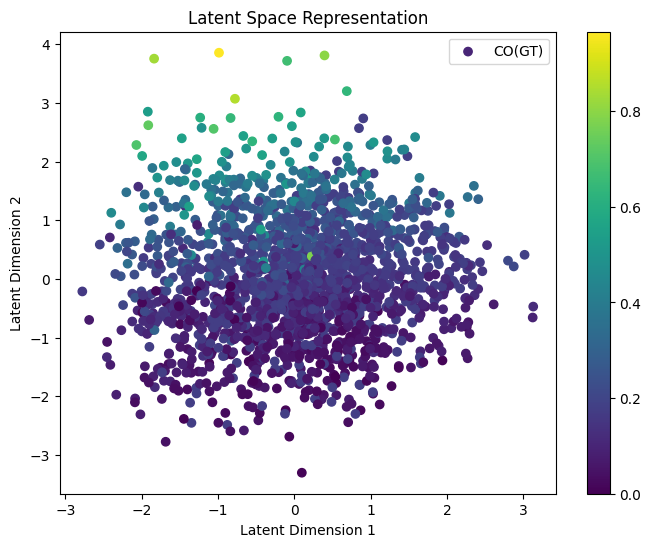

In [59]:
# Encode the data to get the latent representation
latent_mean, latent_log_var, latent_space = vae.encoder.predict(x_val)
import matplotlib.pyplot as plt

# If latent_dim = 2, plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=x_val[:, 0], cmap='viridis', label='CO(GT)')
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation')
plt.legend()
plt.show()


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


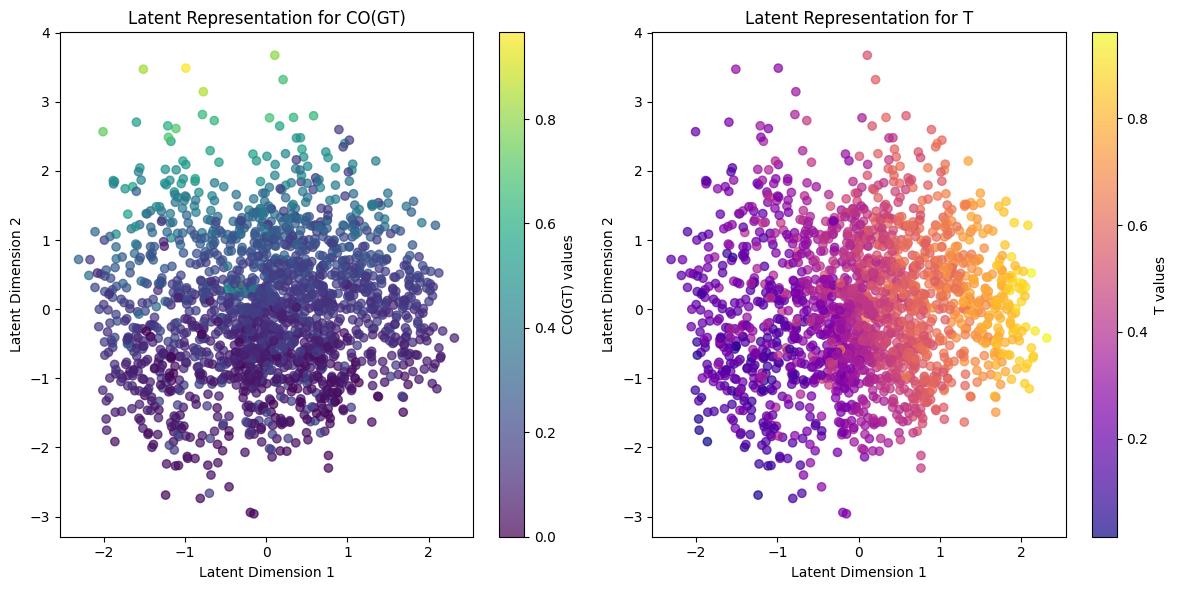

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Define z_mean using the encoder
z_mean, _, _ = vae.encoder.predict(x_val)

# Define original_features for 'CO(GT)' and 'T'
co_column_index = 0  # Column index for 'CO(GT)'
t_column_index = 9   # Column index for 'T'
original_features = x_val[:, [co_column_index, t_column_index]]

# Function to plot the latent space
def plot_latent_space(z_mean, original_features, feature_names):
    plt.figure(figsize=(12, 6))  # Set the figure size

    # Plot latent space for CO(GT)
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=original_features[:, 0], cmap='viridis', alpha=0.7)
    plt.colorbar(label=f'{feature_names[0]} values')
    plt.title(f'Latent Representation for {feature_names[0]}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

    # Plot latent space for T
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=original_features[:, 1], cmap='plasma', alpha=0.7)
    plt.colorbar(label=f'{feature_names[1]} values')
    plt.title(f'Latent Representation for {feature_names[1]}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

# Plot the latent space for 'CO(GT)' and 'T'
feature_names = ['CO(GT)', 'T']
plot_latent_space(z_mean, original_features, feature_names)


In [61]:
correlation = np.corrcoef(x_val[:, co_column_index], x_val[:, t_column_index])[0, 1]
print(f'Correlation between CO(GT) and T: {correlation}')

Correlation between CO(GT) and T: 0.033123898881777865


In [62]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Convert specific columns to a DataFrame
# using column indices 0 for 'CO(GT)' and 9 for 'T'
data_vae = pd.DataFrame(reconstruction_val[:, [0, 9]], columns=['CO(GT)', 'T'])
# Perform Granger causality test
results = grangercausalitytests(data_vae, maxlag=10, verbose=True)

# Check the test results
# p-values are consistently high (mostly above 0.05), there is no statistically significant Granger causality between 'CO(GT)' and 'T' for any of the lag lengths tested.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0070  , p=0.3158  , df_denom=1868, df_num=1
ssr based chi2 test:   chi2=1.0086  , p=0.3152  , df=1
likelihood ratio test: chi2=1.0083  , p=0.3153  , df=1
parameter F test:         F=1.0070  , p=0.3158  , df_denom=1868, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5391  , p=0.5834  , df_denom=1865, df_num=2
ssr based chi2 test:   chi2=1.0810  , p=0.5824  , df=2
likelihood ratio test: chi2=1.0807  , p=0.5825  , df=2
parameter F test:         F=0.5391  , p=0.5834  , df_denom=1865, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3799  , p=0.7675  , df_denom=1862, df_num=3
ssr based chi2 test:   chi2=1.1439  , p=0.7665  , df=3
likelihood ratio test: chi2=1.1435  , p=0.7666  , df=3
parameter F test:         F=0.3799  , p=0.7675  , df_denom=1862, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2962  , p=0.

c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [63]:
# Swap the order of the columns to check if 'T' Granger-causes 'CO(GT)'
data_vae_reversed = pd.DataFrame(reconstruction_val[:, [9, 0]], columns=['T', 'CO(GT)'])
results_reversed = grangercausalitytests(data_vae_reversed, maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7868  , p=0.3752  , df_denom=1868, df_num=1
ssr based chi2 test:   chi2=0.7881  , p=0.3747  , df=1
likelihood ratio test: chi2=0.7879  , p=0.3747  , df=1
parameter F test:         F=0.7868  , p=0.3752  , df_denom=1868, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5584  , p=0.5722  , df_denom=1865, df_num=2
ssr based chi2 test:   chi2=1.1197  , p=0.5713  , df=2
likelihood ratio test: chi2=1.1194  , p=0.5714  , df=2
parameter F test:         F=0.5584  , p=0.5722  , df_denom=1865, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6239  , p=0.5996  , df_denom=1862, df_num=3
ssr based chi2 test:   chi2=1.8787  , p=0.5980  , df=3
likelihood ratio test: chi2=1.8778  , p=0.5982  , df=3
parameter F test:         F=0.6239  , p=0.5996  , df_denom=1862, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4876  , p=0.

c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


#### Previous

In [ ]:
from sklearn.manifold import TSNE

# Visualize the latent space
def plot_latent_space(encoder, x_val):
    mean, _, latent_space = encoder.predict(x_val)
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(latent_space)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_latent_space(vae.encoder, x_val)

In [12]:
# The latent space is effectively capturing the diversity and uniqueness of each data point or not
def check_latent_space_diversity(encoder, x_val):
    mean, _, latent_space = encoder.predict(x_val)
    unique_latent_vectors = np.unique(latent_space, axis=0)
    print(f'Number of unique latent vectors: {unique_latent_vectors.shape[0]} out of {latent_space.shape[0]} samples')

check_latent_space_diversity(vae.encoder, x_val) # it is capturing


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of unique latent vectors: 1872 out of 1872 samples


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


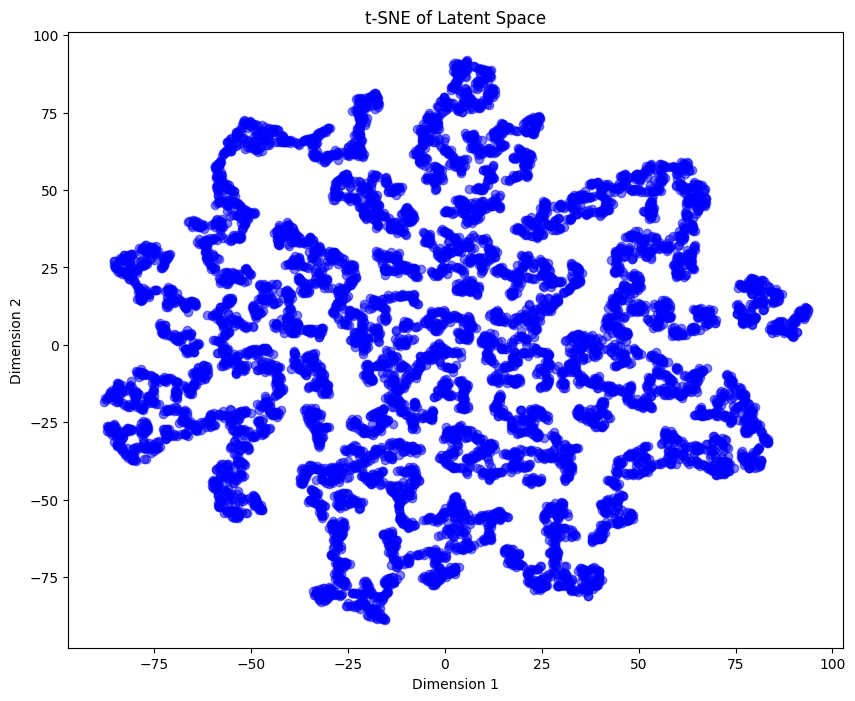

In [13]:
from sklearn.manifold import TSNE
def plot_latent_space(encoder, x_test):
    # Encode the dataset into the latent space
    _, _, latent_space = encoder.predict(x_test)
    
    # Use t-SNE to reduce the dimensionality of the latent space to 2D
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(latent_space)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_latent_space(vae.encoder, data_scaled)


In [14]:
def check_latent_space_diversity(encoder, data_scaled):
    mean, _, latent_space = encoder.predict(data_scaled)
    unique_latent_vectors = np.unique(latent_space, axis=0)
    print(f'Number of unique latent vectors: {unique_latent_vectors.shape[0]} out of {latent_space.shape[0]} samples')

check_latent_space_diversity(vae.encoder, data_scaled)

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of unique latent vectors: 9357 out of 9357 samples


In [15]:
# After training, encode the data to get latent representations
latent_representations = vae.encode(data_scaled)

# analyze the latent representations to explore potential relationships
print(latent_representations)

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
[array([[ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       ...,
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06]], dtype=float32), array([[-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       ...,
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07]], dtype=float32), array([[-0.3057483 ,  1.9567777 ],
       [-0.92660564,  0.30101672],
       [ 0.5633404 ,  0.8702434 ],
       ...,
       [-0.19821277,  0.20076936],
       [-0.5058816 , -0.5996393 ],
       [ 0.28200623, -1.4631588 ]], dtype=float32)]


The first array:  contains the values from the mean layer of the encoder.

The second array:  contains the values from the log variance layer of the encoder.

The third array:  contains the actual sampled latent space representations. (focus on it)

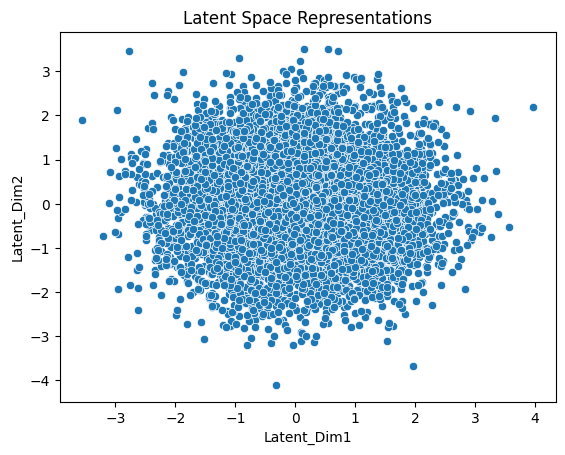

In [16]:
latent_space_representations = latent_representations[2]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to a DataFrame for easier manipulation and visualization
latent_df = pd.DataFrame(latent_space_representations, columns=['Latent_Dim1', 'Latent_Dim2'])

# Visualize the latent space
sns.scatterplot(x='Latent_Dim1', y='Latent_Dim2', data=latent_df)
plt.title('Latent Space Representations')
plt.show()

In [17]:
latent_df['T'] = df['T'].values
latent_df['RH'] = df['RH'].values

correlation_matrix = latent_df.corr()
print(correlation_matrix)

             Latent_Dim1  Latent_Dim2         T        RH
Latent_Dim1     1.000000    -0.016000  0.011337 -0.018877
Latent_Dim2    -0.016000     1.000000 -0.013407  0.008120
T               0.011337    -0.013407  1.000000 -0.578569
RH             -0.018877     0.008120 -0.578569  1.000000


analyze the causal effect of 'Temperature' (T) on 'CO(GT)'

In [18]:
import dowhy
from dowhy import CausalModel
import pandas as pd

# `df` is original DataFrame and `latent_df` contains the latent representations

# Choose your variables of interest
df['Latent_Dim1'] = latent_space_representations[:, 0]
df['Latent_Dim2'] = latent_space_representations[:, 1]

treatment = 'T'
outcome = 'CO(GT)'

# Create the causal model
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=['Latent_Dim1', 'Latent_Dim2','RH','AH'],  # Include other variables as needed
)

# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                           
────(E[CO(GT)|Latent_Dim1,AH,Latent_Dim2,RH])
d[T]                                         
Estimand assumption 1, Unconfoundedness: If U→{T} and U→CO(GT) then P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH,U) = P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:

# Estimate the causal effect using a specified method
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")

print(causal_estimate)

# Mean value: On average, a one-unit increase in T is associated with a 0.0326 unit increase in CO(GT).

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                           
────(E[CO(GT)|Latent_Dim1,AH,Latent_Dim2,RH])
d[T]                                         
Estimand assumption 1, Unconfoundedness: If U→{T} and U→CO(GT) then P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH,U) = P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH)

## Realized estimand
b: CO(GT)~T+Latent_Dim1+AH+Latent_Dim2+RH
Target units: ate

## Estimate
Mean value: 0.032607189440317264



In [20]:
# Refute the causal effect estimate to check robustness
refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.032607189440317264
New effect:-7.105427357601002e-15
p value:0.0



Causal estimation: temperature (T) has a small but positive effect on CO(GT). 

The robustness check using a placebo treatment shows that the estimated effect is likely robust, as the placebo treatment had no significant effect.

### Prepare dataset iVAE

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extract additional features if needed
df_copy_ivae = df.copy()
df_copy_ivae['year'] = df['datetime'].dt.year
df_copy_ivae['month'] = df['datetime'].dt.month
df_copy_ivae['day'] = df['datetime'].dt.day
df_copy_ivae['hour'] = df['datetime'].dt.hour

# Select features for scaling
features_to_scale = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 
                     'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
                     'PT08.S5(O3)', 'T', 'RH', 'AH']

scaler = StandardScaler()
df_copy_ivae[features_to_scale] = scaler.fit_transform(df_copy_ivae[features_to_scale])

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df_copy_ivae['season'] = df_copy_ivae['month'].apply(get_season) # analyze different seasons separately
df_copy_ivae['environment'] = df_copy_ivae['season']

#print(df_copy_ivae.head(1))

# One-hot encode the 'season' column
df_encoded = pd.get_dummies(df_copy_ivae, columns=['season'])
df_encoded = df_encoded.drop(['year','month','day','hour'], axis=1)
print(df_encoded.head(1))

             datetime    CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
0 2004-03-10 18:00:00  0.339856     1.223265  0.246331       0.407086   

    NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T  \
0 -0.418187       0.87745 -0.00172       0.69503      0.62654 -0.544709   

         RH       AH environment  season_Fall  season_Spring  season_Summer  \
0 -0.021054 -0.67652      Spring            0              1              0   

   season_Winter  
0              0  


### check target 'T':

In [17]:
from sklearn.model_selection import train_test_split

# Features and environment labels
# features = df_encoded.drop(['datetime', 'CO(GT)', 'T'], axis=1)
# target = df_encoded[['CO(GT)', 'T']]

# Keep 'CO(GT)' in the features, but use other features as well
features = df_encoded.drop(['datetime', 'T'], axis=1)  # Include 'CO(GT)' and other variables
target = df_encoded[['T']]  # Target is 'T'

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train = X_train.drop('environment', axis=1)
X_test = X_test.drop('environment', axis=1)

# Assuming 'environment' columns were created during one-hot encoding
environment_train = X_train.filter(like='season_')
environment_test = X_test.filter(like='season_')

# Feature matrices
X_train_features = X_train.drop(environment_train.columns, axis=1)
X_test_features = X_test.drop(environment_test.columns, axis=1)

# Feature matrices and environment labels
# Training: Used for learning the model parameters.
X_train_final = X_train_features.values
env_train_final = environment_train.values

# Evaluation: Used for assessing the model’s performance on unseen data and ensuring generalization.
X_test_final = X_test_features.values
env_test_final = environment_test.values

print(X_train_final.shape) # (7485, 11)
print(env_train_final.shape) # (7485, 4)
print(X_test_final.shape) # (1872, 11)
print(env_test_final.shape) # (1872, 4)

(7485, 11)
(7485, 4)
(1872, 11)
(1872, 4)


### iVAE

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Layer, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

class iVAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(iVAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_layer, reconstruction, mean_layer, log_var_layer, condition_layer = inputs
        reconstruction_loss = MeanSquaredError()(input_layer, reconstruction)
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var_layer - tf.square(mean_layer) - tf.exp(log_var_layer), axis=-1)
        
        condition_diff = tf.reduce_mean(tf.square(condition_layer - tf.stop_gradient(condition_layer)))

        total_loss = reconstruction_loss + kl_loss* 0.01 + condition_diff
        self.add_loss(tf.reduce_mean(total_loss))
        
        return reconstruction
    
class iVAE:
    def __init__(self, input_shape, latent_dim, condition_dim):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def build_encoder(self):
        # input_layer = Input(shape=self.input_shape)
        # condition_layer = Input(shape=(self.condition_dim,))
        input_layer = Input(shape=(self.input_shape,), name='encoder_input')
        condition_layer = Input(shape=(self.condition_dim,), name='condition_input')
        
        concat_input = tf.keras.layers.Concatenate()([input_layer, condition_layer])
        
        hidden_layer1 = Dense(256, activation='relu')(concat_input)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(64, activation='relu')(hidden_layer2)

        mean_layer = Dense(self.latent_dim)(hidden_layer3)
        log_var_layer = Dense(self.latent_dim)(hidden_layer3)

        def sampling(args):
            mean, log_var = args
            batch = tf.shape(mean)[0]
            dim = tf.shape(mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return mean + tf.exp(0.5 * log_var) * epsilon

        latent_space = Lambda(sampling)([mean_layer, log_var_layer])

        encoder = Model([input_layer, condition_layer], [mean_layer, log_var_layer, latent_space, condition_layer], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        condition_layer = Input(shape=(self.condition_dim,))
        
        concat_latent = tf.keras.layers.Concatenate()([latent_inputs, condition_layer])
        
        hidden_layer1 = Dense(64, activation='relu')(concat_latent)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        
        # flat_output = Dense(np.prod(self.input_shape), activation='sigmoid')(hidden_layer3)
        # Use linear activation for continuous outputs
        flat_output = Dense(np.prod((self.input_shape,)), activation='linear')(hidden_layer3)
        output_layer = Reshape((self.input_shape,))(flat_output)

        decoder = Model([latent_inputs, condition_layer], output_layer, name='decoder')
        return decoder

    def build_vae(self):
        #input_layer = Input(shape=self.input_shape)
        #condition_layer = Input(shape=(self.condition_dim,))
        input_layer = Input(shape=(self.input_shape,), name='vae_input')
        condition_layer = Input(shape=(self.condition_dim,), name='vae_condition_input')
        
        
        mean_layer, log_var_layer, latent_space, condition_output = self.encoder([input_layer, condition_layer])
        reconstruction = self.decoder([latent_space, condition_layer])

        output_with_loss = iVAELossLayer()([input_layer, reconstruction, mean_layer, log_var_layer, condition_output])

        vae = Model([input_layer, condition_layer], output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.0001))
        return vae

    def train(self, x_train, condition_train, batch_size, epochs):
        self.vae.fit([x_train, condition_train], x_train, batch_size=batch_size, epochs=epochs, verbose=1)

    def encode(self, x, c):
        #return self.encoder.predict([x, c])
        latent_representation = self.encoder([x, c])
        return latent_representation

    def decode(self, z, c):
        reconstructed_data = self.decoder([z, c])
        return reconstructed_data
        #return self.decoder.predict([z, c])
    
    def predict(self, x, c):
        return self.vae.predict([x, c])
    
    def reconstruct(self, X, env):
        # Step 1: Get latent representation from the encoder
        # Encoder returns [mean_layer, log_var_layer, latent_space, condition_output]
        _, _, latent_representation, _ = self.encode(X, env)
        # Step 2: Ensure env (condition) is converted to a tensor
        env_tensor = tf.convert_to_tensor(env, dtype=tf.float32)

        # Step 3: Reconstruct data using the decoder with tensors
        reconstructed_data = self.decode(latent_representation, env_tensor)
        return reconstructed_data
    

### iVAE Training begin 'CO' and 'T'

In [20]:
input_shape = X_train_final.shape[1]
condition_dim = env_train_final.shape[1]  # Number of one-hot encoded season labels

ivae_model = iVAE(input_shape=input_shape, latent_dim=2, condition_dim=condition_dim)
ivae_model.train(X_train_final, env_train_final, batch_size=64, epochs=30)



Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9796
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4598
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2859
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2411
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2243
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2120
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2057
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2040
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2002
Epoch 10/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1970
Epoch 11/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1920
Epoch 12/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1897
Epoch 13/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1876
Epoch 14/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1886
Epoch 15/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Reconstruct the data
reconstructed_data = ivae_model.reconstruct(X_test_final, env_test_final)

# Compute the reconstruction error (Mean Squared Error)
mse = mean_squared_error(X_test_final, reconstructed_data)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.12807437777519226


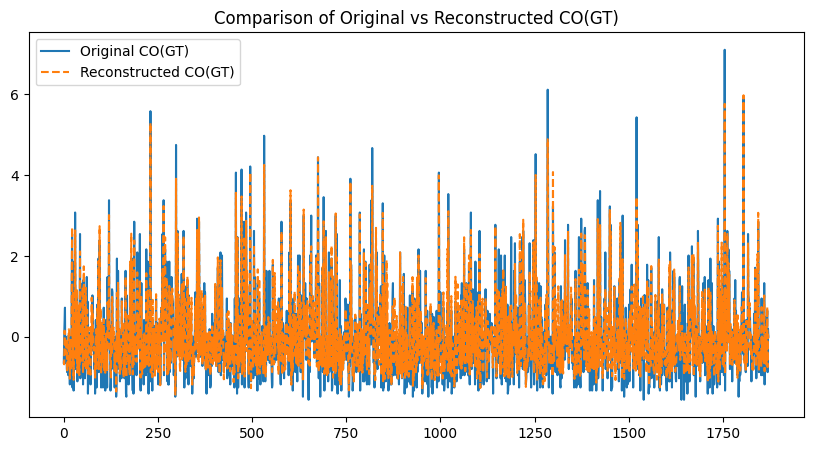

In [22]:
# Example for one feature (CO(GT))
plt.figure(figsize=(10,5))
plt.plot(X_test_final[:, 0], label='Original CO(GT)')
plt.plot(reconstructed_data[:, 0], label='Reconstructed CO(GT)', linestyle='--')
plt.legend()
plt.title("Comparison of Original vs Reconstructed CO(GT)")
plt.show()

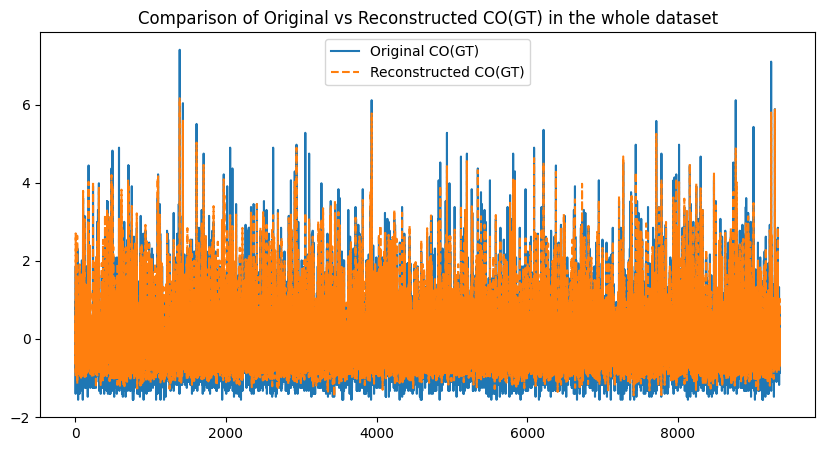

In [26]:
# Reconstruct all data
# Combine training and test data
X_full = np.concatenate((X_train_final, X_test_final), axis=0)
env_full = np.concatenate((env_train_final, env_test_final), axis=0)
T_full = np.concatenate((y_train, y_test), axis=0)

reconstructed_data_full = ivae_model.reconstruct(X_full, env_full)

plt.figure(figsize=(10,5))
plt.plot(X_full[:, 0], label='Original CO(GT)')
plt.plot(reconstructed_data_full[:, 0], label='Reconstructed CO(GT)', linestyle='--')
plt.legend()
plt.title("Comparison of Original vs Reconstructed CO(GT) in the whole dataset")
plt.show()

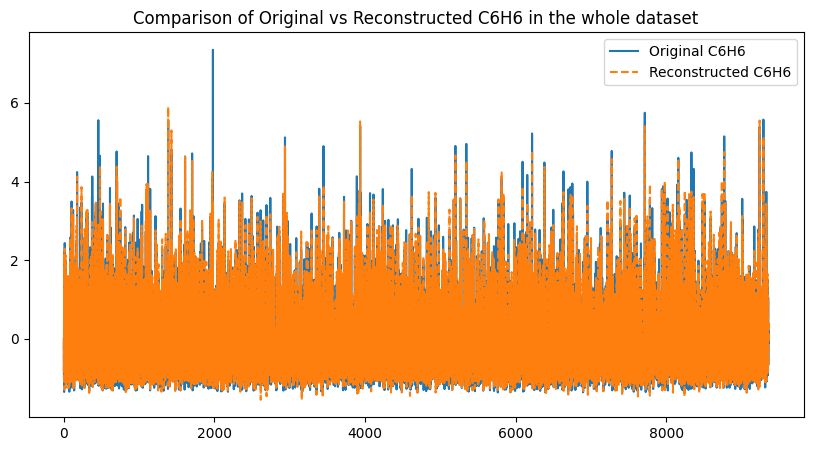

In [45]:
plt.figure(figsize=(10,5))
plt.plot(X_full[:, 2], label='Original C6H6')
plt.plot(reconstructed_data_full[:, 2], label='Reconstructed C6H6', linestyle='--')
plt.legend()
plt.title("Comparison of Original vs Reconstructed C6H6 in the whole dataset")
plt.show()

In [44]:
print(X_full.shape)
print(T_full.shape)
print(reconstructed_data_full.shape)

(9357, 11)
(9357, 1)
(9357, 11)


In [25]:
print(features.columns)  # This will show you the order of the columns
print(target.columns)
print(" ")

print(reconstructed_data.shape)  # Check how many features are included
print(X_test_final.shape)
print(" ")

print(X_train_features.columns)
print(environment_train.columns)
print(y_train.columns)

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH',
       'environment', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')
Index(['T'], dtype='object')
 
(1872, 11)
(1872, 11)
 
Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH'],
      dtype='object')
Index(['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter'], dtype='object')
Index(['T'], dtype='object')


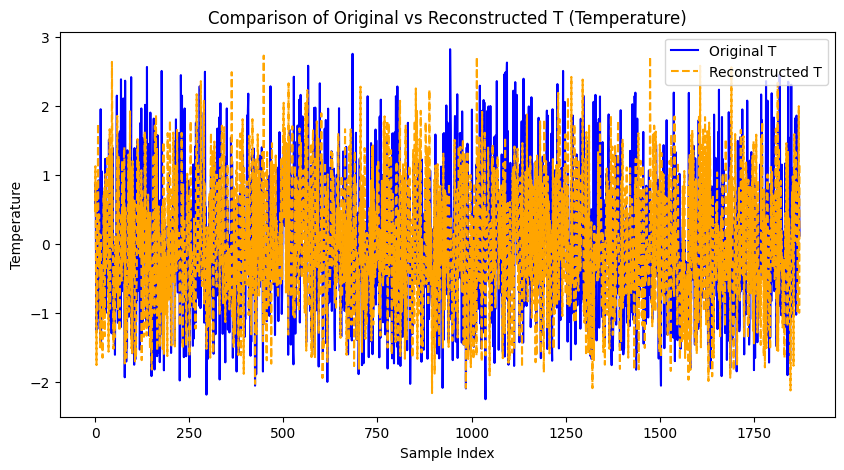

In [19]:
# Original T values from the target DataFrame
original_T = y_test['T'].values  # Extract original T values from the target DataFrame

# If your reconstructed_data contains the same order of features,
# make sure to adjust to plot correctly if needed.
# For example, if T is not part of the reconstructed_data:
# Here we assume you want to visualize the original T against a reconstruction based on other features.

plt.figure(figsize=(10, 5))
plt.plot(original_T, label='Original T', color='blue')  # Original temperature values
plt.plot(reconstructed_data[:, -1], label='Reconstructed T', linestyle='--', color='orange')  # Adjust index if needed
plt.legend()
plt.title("Comparison of Original vs Reconstructed T (Temperature)")
plt.xlabel("Sample Index")  # Optional: Label for the x-axis
plt.ylabel("Temperature")    # Optional: Label for the y-axis
plt.show()


In [ ]:
# Plot for 'T' (Temperature)
# plt.figure(figsize=(10,5))
#plt.plot(X_test_final[:, 1], label='Original T')  # Assuming 'T' is the second column (index 1)
#plt.plot(reconstructed_data[:, 1], label='Reconstructed T', linestyle='--')
#plt.legend()
#plt.title("Comparison of Original vs Reconstructed T (Temperature)")
#plt.show()

In [ ]:
# latent_representations = ivae_model.encode(X_test_final, env_test_final)
#plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=env_test_final[:, 0], cmap='viridis')  # Color by one of the environmental labels
plt.colorbar(scatter, label='Environmental Condition (Season)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation')
plt.show()


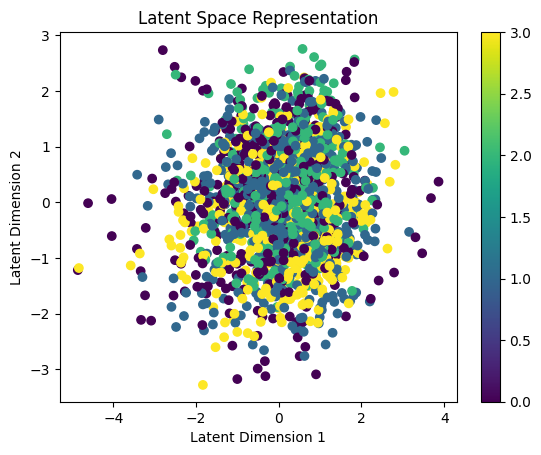

In [20]:
latent_representation = ivae_model.encode(X_test_final, env_test_final)
# Extract only the latent space from the latent_representation
latent_space = latent_representation[2]

# Assuming 'latent_representation' is a list, convert it to a NumPy array
latent_space = np.array(latent_space)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=env_test_final.argmax(axis=1))
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation')
plt.show()


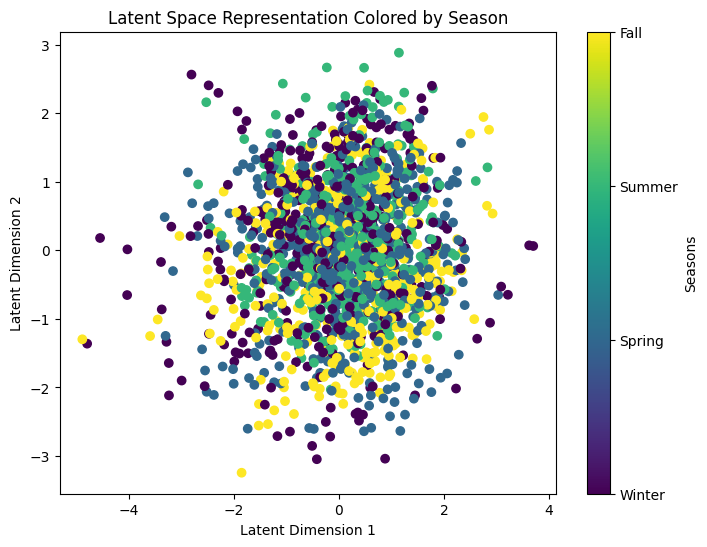

In [21]:
# Extract the latent representation
latent_representation = ivae_model.encode(X_test_final, env_test_final)[2]

# Assuming env_test_final is one-hot encoded, use argmax to get the season index
season_indices = env_test_final.argmax(axis=1)

plt.figure(figsize=(8, 6))
# Scatter plot of the latent space, colored by the season
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=season_indices, cmap='viridis')
plt.colorbar(ticks=range(4), label='Seasons', format=plt.FuncFormatter(lambda x, _: ['Winter', 'Spring', 'Summer', 'Fall'][int(x)]))
plt.title('Latent Space Representation Colored by Season')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


In [ ]:
# Assuming X_test_final and env_test_final are your test data and environmental conditions
#latent_representation = ivae_model.encode(X_test_final, env_test_final)[2]  # Index 2 gets the latent space
#plt.figure(figsize=(8,6))
# Scatter plot of the latent space, colored by 'T' (assuming 'T' is at index 1 in X_test_final)
#plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=X_test_final[:, 1], cmap='viridis')
#plt.colorbar(label='Temperature (T)')
#plt.title('Latent Space Representation colored by Temperature (T)')
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.show()


In [22]:
print(y_test.shape)
print(reconstructed_data.shape)

(1872, 1)
(1872, 11)


### Test in 20% dataset

In [91]:
# Test for feature and T
#'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
#'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH'
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

#feature_names = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']  # List feature names
feature_indices = {
    'CO(GT)': 0,        # corresponds to 'CO(GT)' in reconstructed_data
    'C6H6(GT)': 2,      # corresponds to 'C6H6(GT)' in reconstructed_data
    'PT08.S2(NMHC)': 3,
    'NOx(GT)': 4,       # corresponds to 'NOx(GT)' in reconstructed_data
    'NO2(GT)': 6,        # corresponds to 'NO2(GT)' in reconstructed_data
    'PT08.S5(O3)':8
}

for feature, idx in feature_indices.items():
    data_dict = {
        feature: reconstructed_data[:, idx],  
        'T': y_test.values.ravel()
    }
    df_ivae = pd.DataFrame(data=data_dict)
    
    print(f"Testing Causal Effect of {feature} on T:")
    grangercausalitytests(df_ivae[[feature, 'T']], maxlag=10)
    
    print(f"Testing Causal Effect of T on {feature}:")
    grangercausalitytests(df_ivae[['T', feature]], maxlag=10)


Testing Causal Effect of CO(GT) on T:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2810  , p=0.5961  , df_denom=1868, df_num=1
ssr based chi2 test:   chi2=0.2814  , p=0.5958  , df=1
likelihood ratio test: chi2=0.2814  , p=0.5958  , df=1
parameter F test:         F=0.2810  , p=0.5961  , df_denom=1868, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2824  , p=0.7540  , df_denom=1865, df_num=2
ssr based chi2 test:   chi2=0.5664  , p=0.7534  , df=2
likelihood ratio test: chi2=0.5663  , p=0.7534  , df=2
parameter F test:         F=0.2824  , p=0.7540  , df_denom=1865, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2871  , p=0.8348  , df_denom=1862, df_num=3
ssr based chi2 test:   chi2=0.8644  , p=0.8340  , df=3
likelihood ratio test: chi2=0.8642  , p=0.8341  , df=3
parameter F test:         F=0.2871  , p=0.8348  , df_denom=1862, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

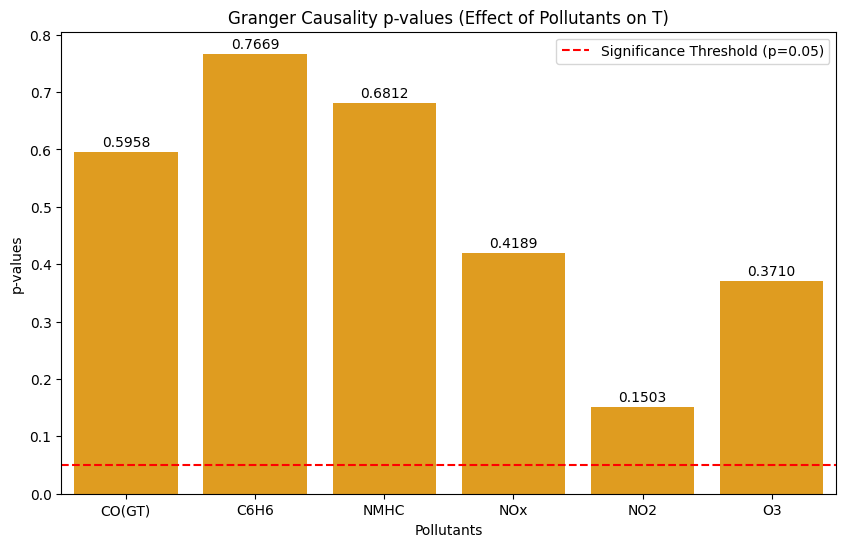

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
p_values = [0.5958, 0.7669, 0.6812, 0.4189, 0.1503, 0.3710]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='orange')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Granger Causality p-values (Effect of Pollutants on T)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value + 0.01, f'{p_value:.4f}', ha='center', color='black')

plt.show()


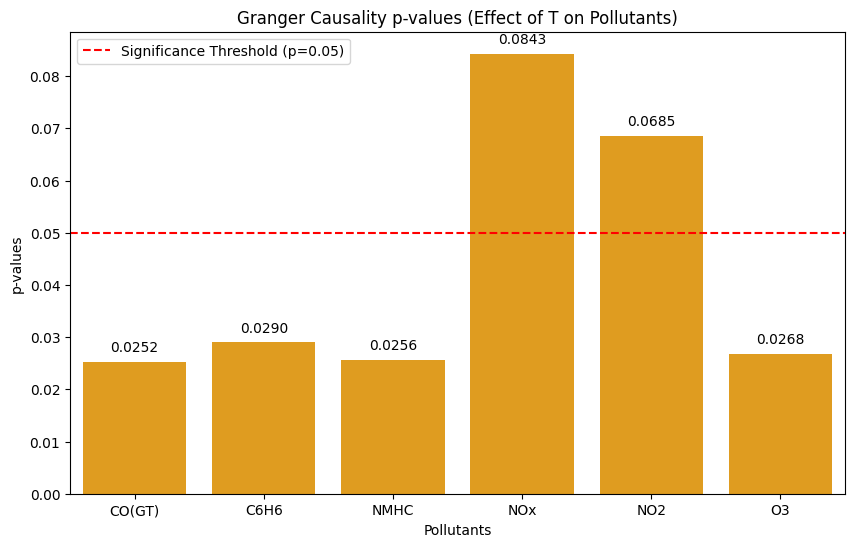

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
p_values = [0.0252, 0.0290, 0.0256, 0.0843, 0.0685, 0.0268]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='orange')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Granger Causality p-values (Effect of T on Pollutants)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value+0.002, f'{p_value:.4f}', ha='center', color='black')

plt.show()


### Test in the full dataset

In [56]:
# Test in the full dataset
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

feature_indices = {
    'CO(GT)': 0,        
    'C6H6(GT)': 2,      
    'PT08.S2(NMHC)': 3,
    'NOx(GT)': 4,       
    'NO2(GT)': 6        
}
for feature, idx in feature_indices.items():
    data_dict = {
        feature: reconstructed_data[:, idx],  
        'T': y_test.values.ravel()
    }
    df_ivae = pd.DataFrame(data=data_dict)
    
    print(f"Testing Causal Effect of {feature} on T:")
    grangercausalitytests(df_ivae[[feature, 'T']], maxlag=10)
    
    print(f"Testing Causal Effect of T on {feature}:")
    grangercausalitytests(df_ivae[['T', feature]], maxlag=10)

Testing Causal Effect of CO(GT) on T:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2810  , p=0.5961  , df_denom=1868, df_num=1
ssr based chi2 test:   chi2=0.2814  , p=0.5958  , df=1
likelihood ratio test: chi2=0.2814  , p=0.5958  , df=1
parameter F test:         F=0.2810  , p=0.5961  , df_denom=1868, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2824  , p=0.7540  , df_denom=1865, df_num=2
ssr based chi2 test:   chi2=0.5664  , p=0.7534  , df=2
likelihood ratio test: chi2=0.5663  , p=0.7534  , df=2
parameter F test:         F=0.2824  , p=0.7540  , df_denom=1865, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2871  , p=0.8348  , df_denom=1862, df_num=3
ssr based chi2 test:   chi2=0.8644  , p=0.8340  , df=3
likelihood ratio test: chi2=0.8642  , p=0.8341  , df=3
parameter F test:         F=0.2871  , p=0.8348  , df_denom=1862, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

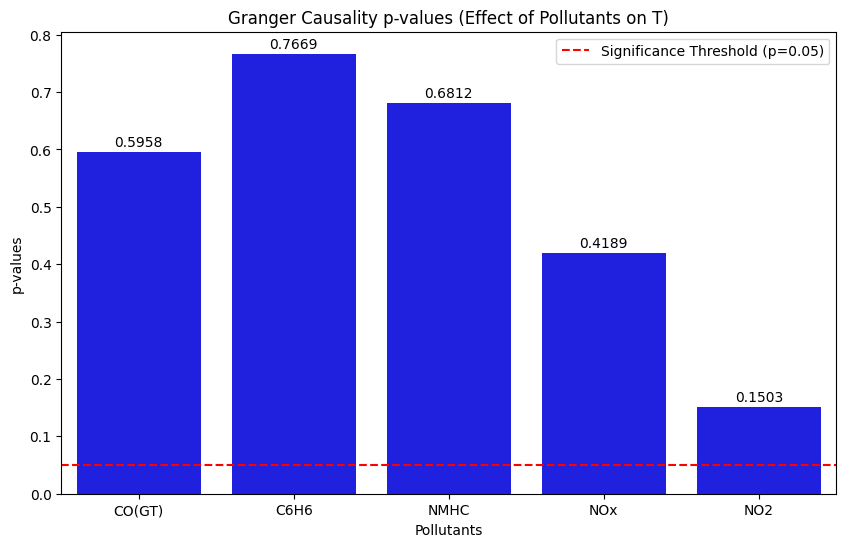

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2']
p_values = [0.5958, 0.7669, 0.6812, 0.4189, 0.1503]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Granger Causality p-values (Effect of Pollutants on T)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value + 0.01, f'{p_value:.4f}', ha='center', color='black')

plt.show()

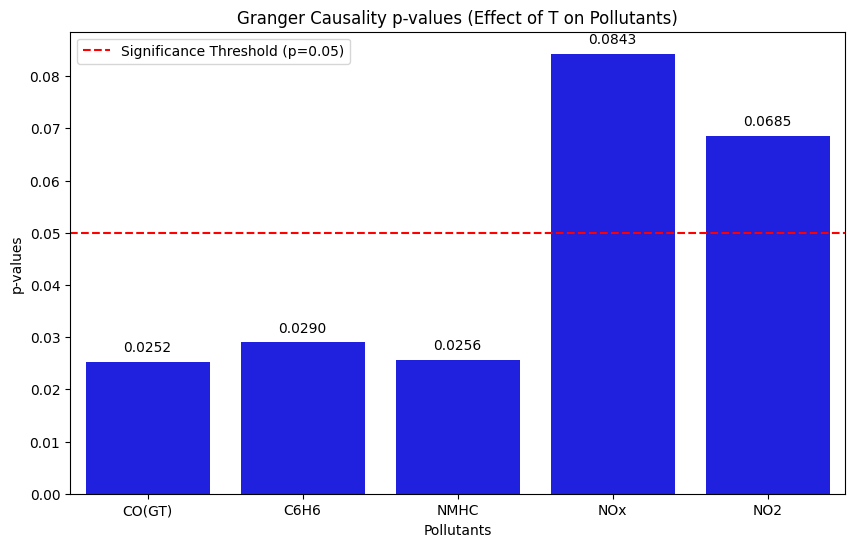

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2']
p_values = [0.0252, 0.0290, 0.0256, 0.0843, 0.0685]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pollutants, y=p_values, color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Granger Causality p-values (Effect of T on Pollutants)')
plt.legend()

# Annotate each bar with the exact p-value
for i, p_value in enumerate(p_values):
    ax.text(i, p_value + 0.002, f'{p_value:.4f}', ha='center', color='black')

plt.show()

### Combine result pictures

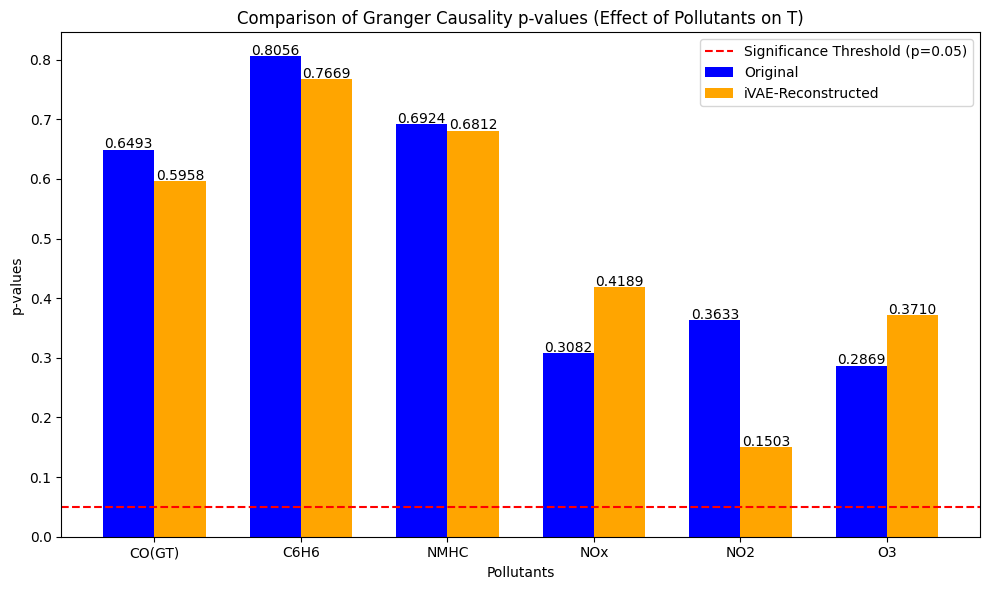

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for original p-values
pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
original_p_values = [0.6493, 0.8056, 0.6924, 0.3082, 0.3633, 0.2869]
ivae_p_values = [0.5958, 0.7669, 0.6812, 0.4189, 0.1503, 0.3710]

plt.figure(figsize=(10, 6))

# Set the positions for the two bars (Original and iVAE)
bar_width = 0.35
index = np.arange(len(pollutants))

# Plot original p-values
ax = plt.bar(index, original_p_values, bar_width, label='Original', color='blue')

# Plot iVAE p-values
ax2 = plt.bar(index + bar_width, ivae_p_values, bar_width, label='iVAE-Reconstructed', color='orange')

# Add horizontal line for significance threshold
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Labels and titles
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Comparison of Granger Causality p-values (Effect of Pollutants on T)')
plt.xticks(index + bar_width / 2, pollutants)  # Position x-ticks between the groups
plt.legend()

# Annotate each bar with the exact p-value (for both Original and iVAE)
for i, p_value in enumerate(original_p_values):
    plt.text(i, p_value + 0.002, f'{p_value:.4f}', ha='center', color='black')
for i, p_value in enumerate(ivae_p_values):
    plt.text(i + bar_width, p_value + 0.002, f'{p_value:.4f}', ha='center', color='black')

# Show the combined plots
plt.tight_layout()
plt.show()


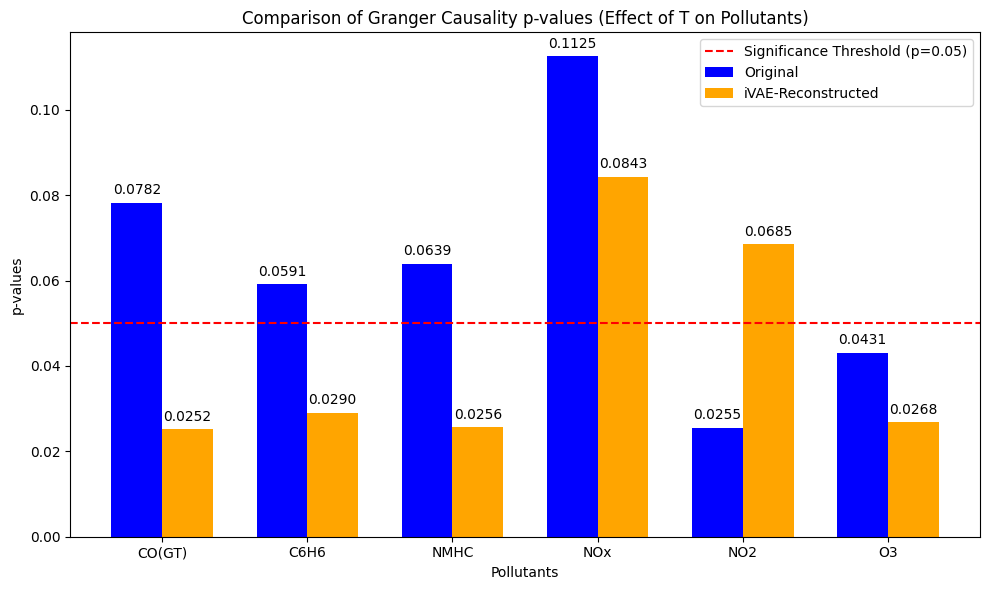

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
pollutants = ['CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
original_p_values = [0.0782, 0.0591, 0.0639, 0.1125, 0.0255, 0.0431]
ivae_p_values = [0.0252, 0.0290, 0.0256, 0.0843, 0.0685, 0.0268]

# Set up the figure
plt.figure(figsize=(10, 6))

# Set the positions for the two bars (Original and iVAE)
bar_width = 0.35
index = np.arange(len(pollutants))

# Plot original p-values
ax = plt.bar(index, original_p_values, bar_width, label='Original', color='blue')

# Plot iVAE p-values
ax2 = plt.bar(index + bar_width, ivae_p_values, bar_width, label='iVAE-Reconstructed', color='orange')

# Add horizontal line for significance threshold
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Labels and titles
plt.xlabel('Pollutants')
plt.ylabel('p-values')
plt.title('Comparison of Granger Causality p-values (Effect of T on Pollutants)')
plt.xticks(index + bar_width / 2, pollutants)  # Position x-ticks between the groups
plt.legend()

# Annotate each bar with the exact p-value (for both Original and iVAE)
for i, p_value in enumerate(original_p_values):
    plt.text(i, p_value + 0.002, f'{p_value:.4f}', ha='center', color='black')
for i, p_value in enumerate(ivae_p_values):
    plt.text(i + bar_width, p_value + 0.002, f'{p_value:.4f}', ha='center', color='black')

plt.tight_layout()
plt.show()


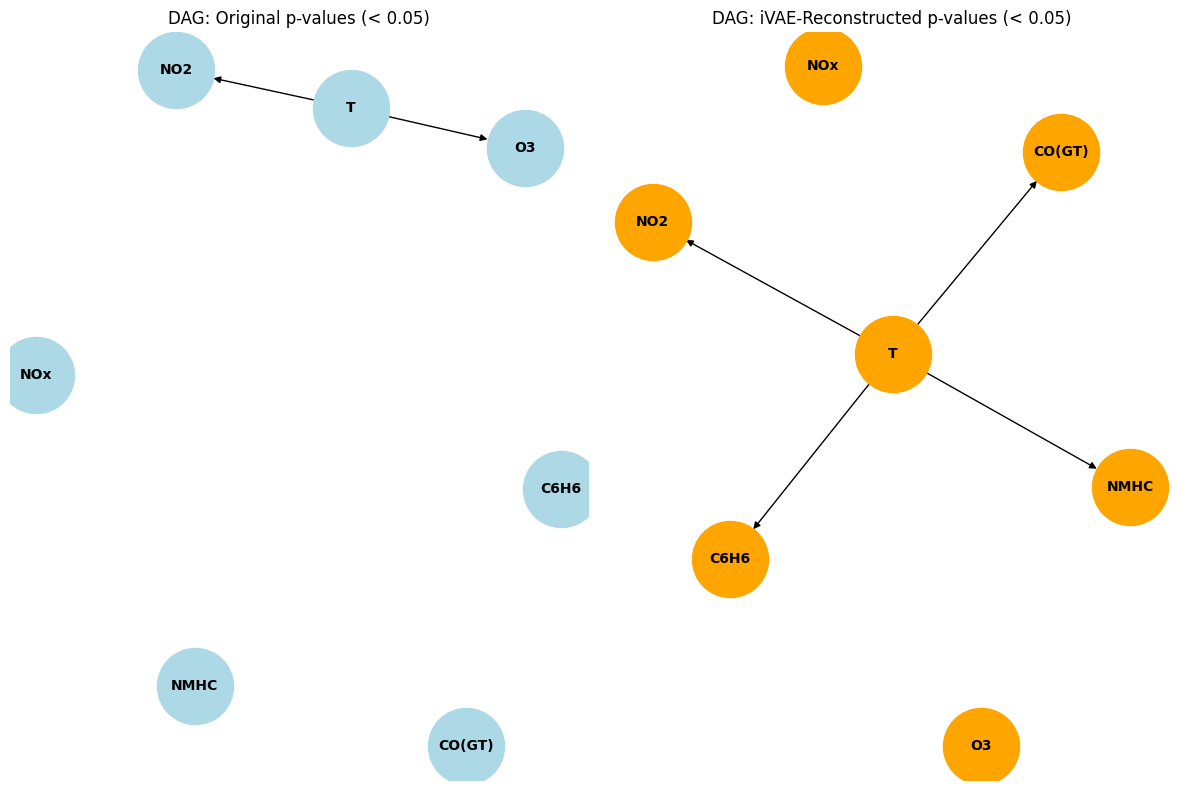

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the directed graphs
dag_original = nx.DiGraph()
dag_ivae = nx.DiGraph()

# Define the nodes (variables)
nodes = ['T', 'CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
dag_original.add_nodes_from(nodes)
dag_ivae.add_nodes_from(nodes)

# Define the directed edges based on original p-values
original_edges = [
    ('T', 'NO2'),  # Original p-value < 0.05
    ('T', 'O3')    # Original p-value < 0.05
]

# Define the directed edges based on iVAE-Reconstructed p-values
iv_edge = [
    ('T', 'CO(GT)'), # iVAE p-value < 0.05
    ('T', 'C6H6'),   # iVAE p-value < 0.05
    ('T', 'NMHC'),   # iVAE p-value < 0.05
    ('T', 'NO2')     # iVAE p-value < 0.05
]

dag_original.add_edges_from(original_edges)
dag_ivae.add_edges_from(iv_edge)

# Draw the graphs
plt.figure(figsize=(12, 8))

# Position for original DAG
plt.subplot(1, 2, 1)
pos_original = nx.spring_layout(dag_original)
nx.draw(dag_original, pos_original, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title('DAG: Original p-values (< 0.05)')

# Position for iVAE DAG
plt.subplot(1, 2, 2)
pos_ivae = nx.spring_layout(dag_ivae)
nx.draw(dag_ivae, pos_ivae, with_labels=True, node_size=3000, node_color='orange', font_size=10, font_weight='bold', arrows=True)
plt.title('DAG: iVAE-Reconstructed p-values (< 0.05)')

# Show the combined figure
plt.tight_layout()
plt.show()


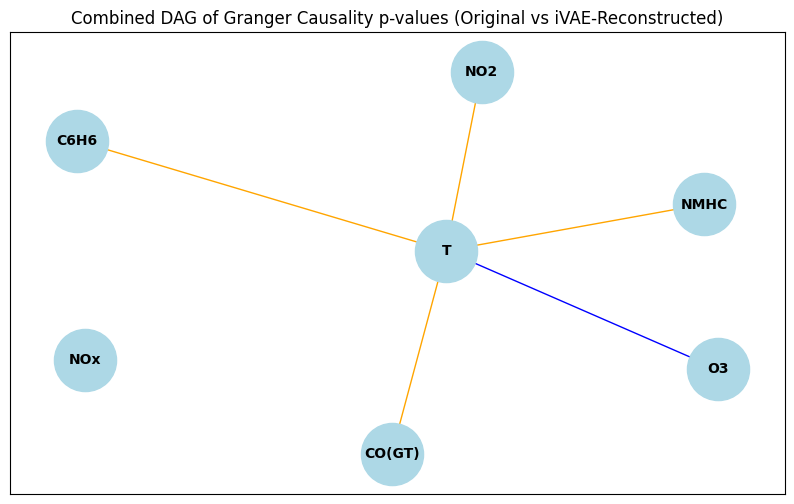

In [112]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
combined_dag = nx.DiGraph()

# Define the nodes (variables)
nodes = ['T', 'CO(GT)', 'C6H6', 'NMHC', 'NOx', 'NO2', 'O3']
combined_dag.add_nodes_from(nodes)

# Define the directed edges with colors
edges = [
    ('T', 'NO2', 'blue'),   # Original edge
    ('T', 'O3', 'blue'),    # Original edge
    ('T', 'CO(GT)', 'orange'), # iVAE edge
    ('T', 'C6H6', 'orange'),   # iVAE edge
    ('T', 'NMHC', 'orange'),   # iVAE edge
    ('T', 'NO2', 'orange')      # iVAE edge (note: multiple edges for NO2)
]

# Add edges to the graph with color attribute
for u, v, color in edges:
    combined_dag.add_edge(u, v, color=color)

# Draw the combined DAG
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(combined_dag)  # positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(combined_dag, pos, node_size=2000, node_color='lightblue')

# Draw edges
edge_colors = [combined_dag[u][v]['color'] for u, v in combined_dag.edges()]
nx.draw_networkx_edges(combined_dag, pos, edge_color=edge_colors, arrows=True)

# Draw labels
nx.draw_networkx_labels(combined_dag, pos, font_size=10, font_weight='bold')

# Set title
plt.title('Combined DAG of Granger Causality p-values (Original vs iVAE-Reconstructed)')
#plt.axis('off')  # Hide the axes
plt.show()
